<a href="https://colab.research.google.com/github/victor-roris/ML-learning/blob/master/ComputerVision/DeepLearning_ComputerVision_DocumentSegmentation_Detectron2_PubLayNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## DEEP LEARNING COMPUTER VISION : DocumentSegmentation - Detectron2 trained on PubLayNet dataset

In this notebook we use a [pretrained Detectron2 model trained with the PubLayNet dataset](https://github.com/hpanwar08/detectron2).

PubLayNet is a very large dataset for document layout analysis (document segmentation). It can be used to trained semantic segmentation/Object detection models.

<img src="https://github.com/hpanwar08/detectron2/blob/master/assets/images/resnext101_32x8d/PMC1247189_00000.jpg?raw=true" data-canonical-src="https://github.com/hpanwar08/detectron2/blob/master/assets/images/resnext101_32x8d/PMC1247189_00000.jpg?raw=true" height="300" />

Detectron2 is Facebook AI Research's next generation software system that implements state-of-the-art object detection algorithms.

In this notebook, we adapt the [Detectron2 tutorial notebook](https://colab.research.google.com/drive/16jcaJoc6bCFAQ96jDe2HwtXj7BMD_-m5) to use the [provided pretrained models](https://github.com/hpanwar08/detectron2).

Links: 
- [Pretrained models](https://github.com/hpanwar08/detectron2)
- [Detectron2](https://github.com/facebookresearch/detectron2)
- [PubLayNet dataset](https://github.com/ibm-aur-nlp/PubLayNet)

### Installation

Detectron2 installation instructions in local : [link](https://github.com/facebookresearch/detectron2/blob/master/INSTALL.md)

In colab notebook:

In [0]:
# install dependencies: (use cu101 because colab has CUDA 10.1)
!pip install -U torch==1.5 torchvision==0.6 -f https://download.pytorch.org/whl/cu101/torch_stable.html 
!pip install cython pyyaml==5.1
!pip install -U 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())
!gcc --version
# opencv is pre-installed on colab

In [0]:
# install detectron2:
!pip install detectron2==0.1.2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/index.html

**NOTE** : You may need to restart your runtime prior to this, to let your installation take effect

## Definition

In [0]:
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import cv2
import random
import matplotlib.pyplot as plt
import math
from pathlib import Path
import os
from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog

## Data

### Test dataset

We are going to use images (`png`) of document pages to test the document segmentation. They are simple pages from a pdf converted to png. 

If in some moment this personal dataset is not available, you simply generate your own dataset or look for a public dataset as [this](https://github.com/ibm-aur-nlp/PubLayNet/tree/master/examples) or [this](http://lampsrv02.umiacs.umd.edu/projdb/edit/userfiles/datasets/Page_Segmentation_Dataset.lzh) about page segmentation.

In [0]:
# Path where the dataset will be stored
testds_path = "./docpages"

In [0]:
# !rm {testds_path} -R

In [0]:
# We create the folder
Path(testds_path).mkdir(parents=True, exist_ok=True)

In [7]:
print(" > Download the test dataset ")
if not os.path.isdir(testds_path):
  !wget https://www.dropbox.com/s/yow9mjgt7cs35c0/validation..doc..pages.tar.gz?dl=0  -O docpages.tar.gz
  !tar -zxvf docpages.tar.gz && ! mv validation..doc..pages {testds_path} 
  !rm docpages.tar.gz

 > Download the test dataset 


In [8]:
from os import listdir
from os.path import isfile, join
testds = [f for f in listdir(testds_path) if isfile(join(testds_path, f))]
print(f'Number of images to test: {len(testds)}')

Number of images to test: 95


### Pre-trained model

To use the pre-trained models in Detectron2 we need the configuration files and model weights.

In the official [github](https://github.com/hpanwar08/detectron2) you can find the current pre-trained models. The current list is:

| Pre-trained Model | Configuration github relative path | 
|----------------------------------|-----------------------------------------------|
| [MaskRCNN Resnext101_32x8d FPN 3X](https://www.dropbox.com/sh/1098ym6vhad4zi6/AABe16eSdY_34KGp52W0ruwha?dl=0) | [configs/DLA_mask_rcnn_X_101_32x8d_FPN_3x.yaml](https://raw.githubusercontent.com/hpanwar08/detectron2/master/configs/DLA_mask_rcnn_X_101_32x8d_FPN_3x.yaml) |
| [MaskRCNN Resnet101 FPN 3X](https://www.dropbox.com/sh/wgt9skz67usliei/AAD9n6qbsyMz1Y3CwpZpHXCpa?dl=0) |  [configs/DLA_mask_rcnn_R_101_FPN_3x.yaml](https://raw.githubusercontent.com/hpanwar08/detectron2/master/configs/DLA_mask_rcnn_R_101_FPN_3x.yaml) | 
| [MaskRCNN Resnet50 FPN 3X](https://www.dropbox.com/sh/44ez171b2qaocd2/AAB0huidzzOXeo99QdplZRjua?dl=0)         | [configs/DLA_mask_rcnn_R_50_FPN_3x.yaml](https://raw.githubusercontent.com/hpanwar08/detectron2/master/configs/DLA_mask_rcnn_R_50_FPN_3x.yaml) |  

Furthermore, this configuration files extends a base configuration file (we need download it too). 

In [0]:
pretrained_models = {
      "MaskRCNN Resnext101_32x8d FPN 3X" : {
        "model_uri" : "https://www.dropbox.com/sh/1098ym6vhad4zi6/AAD8Y-SVN6EbfAWEDYuZHG8xa/model_final_trimmed.pth?dl=0",
        "configuration_uri" : [
          "https://raw.githubusercontent.com/hpanwar08/detectron2/master/configs/DLA_mask_rcnn_X_101_32x8d_FPN_3x.yaml",
          "https://raw.githubusercontent.com/hpanwar08/detectron2/master/configs/Base-RCNN-FPN.yaml"
        ]
      },
      "MaskRCNN Resnet101 FPN 3X" : {
        "model_uri" : "https://www.dropbox.com/sh/wgt9skz67usliei/AADGw0h1y7K5vO0akulyXm-qa/model_final.pth?dl=0",
        "configuration_uri" : [
          "https://raw.githubusercontent.com/hpanwar08/detectron2/master/configs/DLA_mask_rcnn_R_101_FPN_3x.yaml"
        ]
      },
      "MaskRCNN Resnet50 FPN 3X" : {
        "model_uri" : "https://www.dropbox.com/sh/44ez171b2qaocd2/AADysZuCjISY4-biQCO5gTF9a/model_final_trimmed.pth?dl=0",
        "configuration_uri" : [
          "https://raw.githubusercontent.com/hpanwar08/detectron2/master/configs/Base-RCNN-FPN.yaml",
          "https://raw.githubusercontent.com/hpanwar08/detectron2/master/configs/DLA_mask_rcnn_R_50_FPN_3x.yaml"
        ]
      }
}

Select the model to execute

In [0]:
model_choice = "MaskRCNN Resnext101_32x8d FPN 3X" #@param ['MaskRCNN Resnext101_32x8d FPN 3X', 'MaskRCNN Resnet101 FPN 3X', 'MaskRCNN Resnet50 FPN 3X']

In [11]:
print(f"Choosed model : {model_choice}")

Choosed model : MaskRCNN Resnext101_32x8d FPN 3X


Automatic download

In [0]:
premodel_path = "./premodel"

In [0]:
# !rm {premodel_path} -R

In [0]:
# We create the folder
Path(premodel_path).mkdir(parents=True, exist_ok=True)

In [0]:
assert model_choice in pretrained_models, "The selected model is not a valid option"

In [0]:
premodel_metadata = pretrained_models[model_choice]

In [0]:
## Download model
print(" > Download the model : ")
model_path = f"{premodel_path}/{model_choice}.pth"
if not os.path.isfile(model_path): 
  !wget {premodel_metadata["model_uri"]} -O "{model_path}"

In [0]:
## Download the configuration files
print(" > Download the configuration files : ")
for configuration_uri in premodel_metadata["configuration_uri"]:
  filename = configuration_uri.split("/")[-1]

  if not os.path.isfile(premodel_path + "/" + filename): 
    print(f"---- Download the config file : {filename}")
    !wget {configuration_uri} -O "{premodel_path}/{filename}"

  if "Base" not in filename:
    configuration_path = f"{premodel_path}/{filename}"

Class labels of the PubLayNet dataset([link](https://github.com/ibm-aur-nlp/PubLayNet/tree/master/pre-trained-models#convert-pre-trained-model-for-fine-tuning-on-another-target-dataset))

In [0]:
class_labels = {
    0	:	"Text",
    1	:	"Title",
    2	:	"List",
    3	:	"Table",
    4	:	"Figure"
}

## PREDICTION

Load the Detectron2 model

In [19]:
# Create config
cfg = get_cfg()
cfg.merge_from_file(configuration_path)
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5  # set threshold for this model
cfg.MODEL.WEIGHTS = model_path

# Create predictor
predictor = DefaultPredictor(cfg)

WARNING [05/11 14:59:12 d2.config.compat]: Config './premodel/DLA_mask_rcnn_X_101_32x8d_FPN_3x.yaml' has no VERSION. Assuming it to be compatible with latest v2.


Analyse the prediction

Use the image : econreports..001680.png


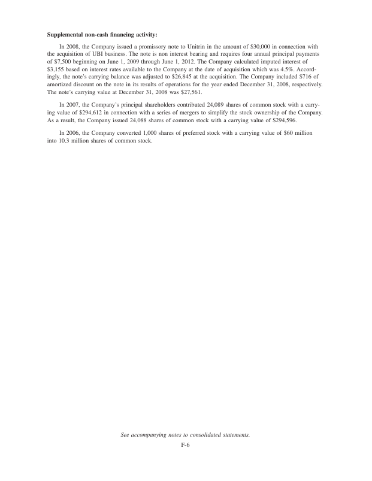

In [20]:
imex = random.choice( testds )
print(f'Use the image : {imex}')

# get image
im = cv2.imread( os.path.join(testds_path,imex) )

# To make easier its visualization I resize the image a lower scale
im = cv2.resize(im.astype('uint8'), (int(im.shape[1]*0.6), int(im.shape[0]*0.6)) )

cv2_imshow(im)

In [0]:
# Make prediction
outputs = predictor(im)

Detectron2 output format: [link](https://detectron2.readthedocs.io/tutorials/models.html#model-output-format)

In [22]:
# look at the outputs. See https://detectron2.readthedocs.io/tutorials/models.html#model-output-format for specification


tensor([0, 0, 1, 0], device='cuda:0')
Boxes(tensor([[ 46.0056,  44.1390, 323.8768,  96.5976],
        [ 47.0664, 102.3194, 322.0998, 125.2152],
        [ 47.0281,  31.8853, 157.7280,  39.4011],
        [ 47.8579, 130.4943, 314.2209, 145.3803]], device='cuda:0'))


Each Box in the Predicted Boxes is a tensor - float matrix of Nx4. Each row is (x1, y1, x2, y2). 

Think, each box is a rectangle, that implies we only need the upper-left vertix (x1,y1) and the lower-right vertix (x2,y2) to reproduce the segment.

In [29]:
print(f'Number of predicted boxes - N = {len(outputs["instances"].pred_boxes)}')

print( outputs["instances"].pred_boxes )

Number of predicted boxes - N = 4
Boxes(tensor([[ 46.0056,  44.1390, 323.8768,  96.5976],
        [ 47.0664, 102.3194, 322.0998, 125.2152],
        [ 47.0281,  31.8853, 157.7280,  39.4011],
        [ 47.8579, 130.4943, 314.2209, 145.3803]], device='cuda:0'))


In [38]:
for i, pclass in enumerate( outputs["instances"].pred_classes ):
  box = outputs["instances"].pred_boxes[i]
  print(f' - {class_labels[pclass.item()]} = {box}')

 - Text = Boxes(tensor([[ 46.0056,  44.1390, 323.8768,  96.5976]], device='cuda:0'))
 - Text = Boxes(tensor([[ 47.0664, 102.3194, 322.0998, 125.2152]], device='cuda:0'))
 - Title = Boxes(tensor([[ 47.0281,  31.8853, 157.7280,  39.4011]], device='cuda:0'))
 - Text = Boxes(tensor([[ 47.8579, 130.4943, 314.2209, 145.3803]], device='cuda:0'))


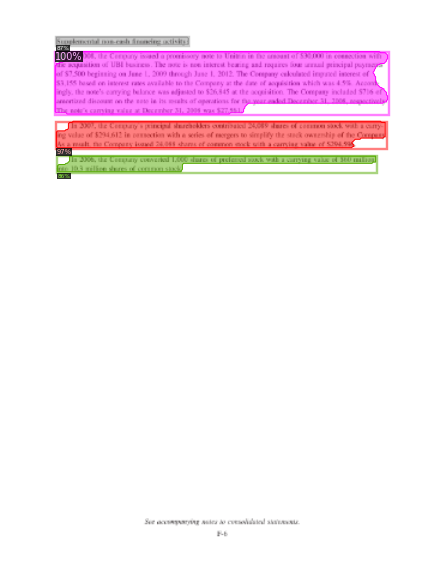

In [23]:
# We can use `Visualizer` to draw the predictions on the image.
v = Visualizer(im[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
cv2_imshow(v.get_image()[:, :, ::-1])

## Visualize a list of predictions

In [0]:
n_predictions= len(testds) #20
imexs = random.choices( testds , k=n_predictions)

outs_preds = []
for imex in imexs:
  im = cv2.imread( os.path.join(testds_path,imex) )
  outputs = predictor(im)
  outs_preds.append((im, outputs))  

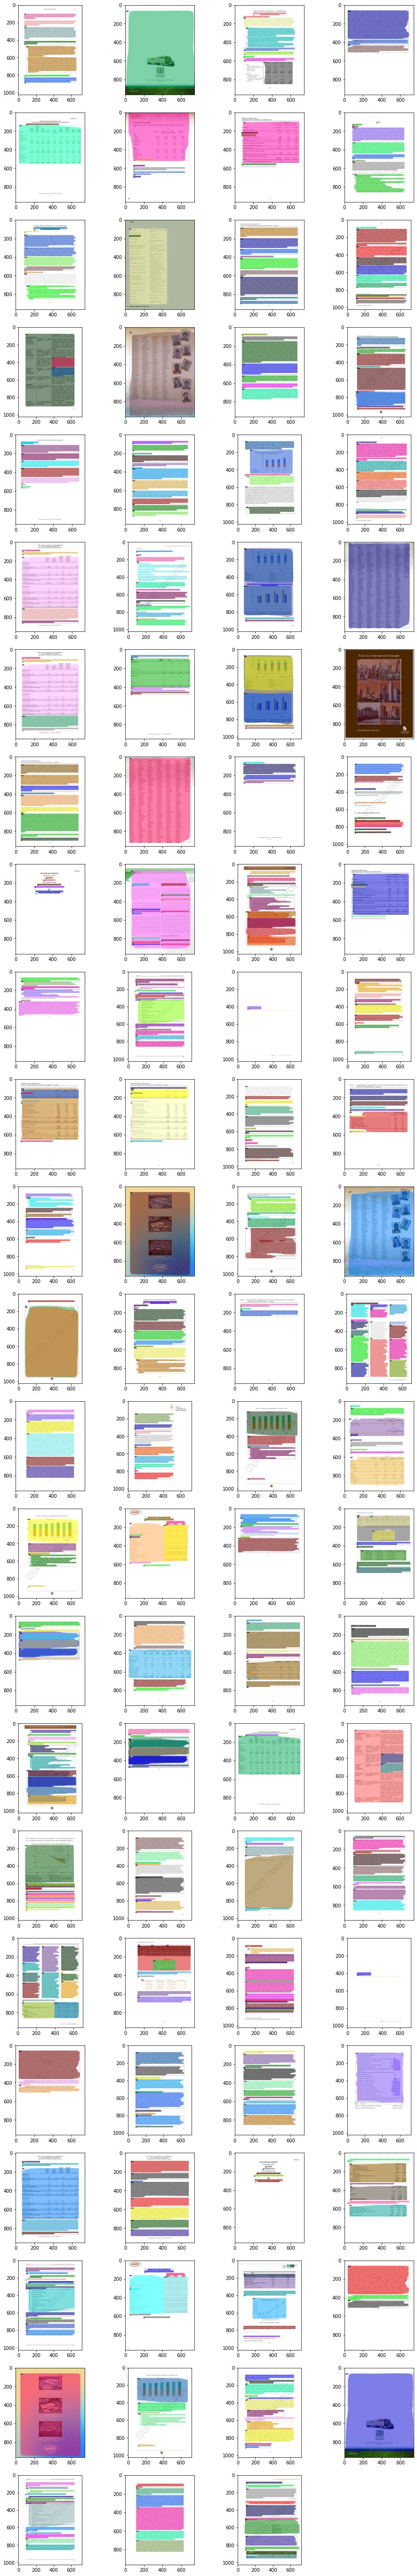

In [63]:
# helper function for data visualization
n = len(outs_preds)

columns = 4
rows = math.ceil(n/columns)

plt.figure(figsize=(16, 100))
for i, (im,outputs) in enumerate(outs_preds):

  plt.subplot(rows, columns, i+1 )
  # We can use `Visualizer` to draw the predictions on the image.
  v = Visualizer(im[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
  v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
  # cv2_imshow(v.get_image()[:, :, ::-1])
  plt.imshow(v.get_image()[:, :, ::-1])
plt.show()